In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import os
from PrepareData import read_json, make_folder

# EXP 1: Comparing to baselines: no intervention and multi-model

## Read results from disc

In [3]:
eval_path='eval/'
# data_name = 'lsac'
# temp_df = pd.read_csv(eval_path+'res-{}.csv'.format(data_name))
# temp_df.head()

In [4]:
# for visualization change the values to be consistent with the order that higher is better
def normalize_fairness_measures(x):
    if 'Diff' in x.iloc[0]: # difference change to 1-abs(x)
        return 1-abs(x.iloc[1])
    
    elif x.iloc[0] == 'DI':
        if x.iloc[1] > 1:
            return min(x.iloc[1], 1/x.iloc[1])
        else:
            return x.iloc[1]
    else:# other metrics
        return x.iloc[1]
def add_vis_flag(x):
    if 'Diff' in x.iloc[0]: # difference change to 1-abs(x)
        if x.iloc[0] in ['ERRDiff', 'FNRDiff', 'FPRDiff']: # measures with lower value means better
            if x.iloc[1] > 0: 
                return 0
            else: # G0 has better outcome
                return 1
        else: # for measures like eqdiff, avgoddsdiff with higher value means better
            if x.iloc[1] < 0: 
                return 0
            else: # G0 has better outcome
                return 1
    
    elif x.iloc[0] == 'DI':
        if x.iloc[1] > 1:
            return 1
        else:
            return 0
    else:# other metrics
        return 0


In [5]:
seeds = [1, 12345, 6, 2211, 15, 88, 121, 433, 500, 1121, 50, 583, 5278, 100000, 0xbeef, 0xcafe, 0xdead, 7777, 100, 923]
# seeds = [88, 121, 433, 500, 1121, 50, 583, 5278, 100000, 0xbeef, 0xcafe, 0xdead, 7777, 100, 923]

models = ['LR', 'TR']

datasets = ['lsac', 'cardio', 'bank', 'meps16', 'credit', 'ACSE', 'ACSP', 'ACSH', 'ACSM', 'ACSI']

In [6]:
eval_suffix = '-min'
# eval_suffix = ''
eval_file = 'scc_mcc_datasets{}_n{}{}.csv'.format(len(datasets), len(seeds), eval_suffix)
if os.path.exists(eval_path+eval_file):
    eval_df = pd.read_csv(eval_path+eval_file)
else:
    eval_df = pd.DataFrame()
    for data_name in datasets:
        cur_eval_df = pd.read_csv(eval_path+'res{}-{}.csv'.format(eval_suffix, data_name))
        cur_eval_df['norm_value'] = cur_eval_df[['metric', 'value']].apply(lambda x: normalize_fairness_measures(x), axis=1)
        cur_eval_df['norm_flag'] = cur_eval_df[['metric', 'value']].apply(lambda x: add_vis_flag(x), axis=1)

        eval_df = pd.concat([eval_df, cur_eval_df])
    
    eval_df.to_csv(eval_path+eval_file, index=False)
    print('Save evaluation results at {}'.format(eval_path+eval_file))

Save evaluation results at eval/scc_mcc_datasets10_n20-min.csv


In [7]:
eval_df.head()

,data,model,seed,method,group,metric,value,norm_value,norm_flag
0,lsac,LR,1,MCC-MIN,all,AUC,0.400000,0.400000,0
1,lsac,LR,1,MCC-MIN,all,ACC,0.667000,0.667000,0
2,lsac,LR,1,MCC-MIN,all,SR,0.833333,0.833333,0
3,lsac,LR,1,MCC-MIN,all,BalAcc,0.400000,0.400000,0
4,lsac,LR,1,MCC-MIN,G0,AUC,0.400000,0.400000,0


In [8]:
eval_df.query('data=="cardio" and method=="OMN-ONE" and group=="all" and metric=="BalAcc"')

,data,model,seed,method,group,metric,value,norm_value,norm_flag
143,cardio,LR,1,OMN-ONE,all,BalAcc,0.5,0.5,0
152,cardio,LR,1,OMN-ONE,all,BalAcc,0.5,0.5,0
323,cardio,LR,12345,OMN-ONE,all,BalAcc,0.5,0.5,0
332,cardio,LR,12345,OMN-ONE,all,BalAcc,0.5,0.5,0
503,cardio,LR,6,OMN-ONE,all,BalAcc,0.5,0.5,0
...,...,...,...,...,...,...,...,...,...
6952,cardio,TR,57005,OMN-ONE,all,BalAcc,0.5,0.5,0
7323,cardio,TR,100,OMN-ONE,all,BalAcc,0.5,0.5,0
7332,cardio,TR,100,OMN-ONE,all,BalAcc,0.5,0.5,0
7523,cardio,TR,923,OMN-ONE,all,BalAcc,0.5,0.5,0


In [9]:
# # extracting evalaution results from different methods with multiple models
# res_path = 'intermediate/models/'
# set_suffix = 'S_1'


# group_eval_metrics = ['AUC', 'ACC', 'SR', 'BalAcc']
# overall_metrics = ['BalAcc', 'DI', 'EQDiff', 'AvgOddsDiff', 'SPDiff', 'FPRDiff', 'FNRDiff', 'ERRDiff']

# methods = ['MCC-MIN', 'MCC-W1', 'MCC-W2', 'SEP', 'ORIG']

# eval_path = 'intermediate/evals/'
# eval_file = 'Data{}-run{}-{}-{}.csv'.format(len(datasets), len(seeds), set_suffix, 'multi')


# all_eval_files = list(filter(lambda x: not os.path.isdir(os.path.join(eval_path, x)), os.listdir(eval_path)))
# if not eval_file in all_eval_files:
#     multi_df = pd.DataFrame(columns=['data', 'seed', 'method', 'group', 'metric', 'value'])

#     for data_name in datasets:
#         for seed in seeds:
#             eval_res = read_json('{}eval-{}-{}-mcc.json'.format(res_path+data_name+'/', seed, set_suffix))
#             for method in methods:
# #                 print(eval_res[method])
                
#                 for group in ['all', 'G0', 'G1']:
#                     base = [data_name, seed, method, group]
#                     for metric_i in group_eval_metrics:
#                         multi_df.loc[multi_df.shape[0]] = base + [metric_i, eval_res[method][group][metric_i]]
#                 for metric_i in overall_metrics:
#                     multi_df.loc[multi_df.shape[0]] = [data_name, seed, method, 'all'] + [metric_i, eval_res[method]['all'][metric_i]]

#     multi_df.to_csv(eval_path+eval_file, index=False)
#     print('Save evaluation results at {}'.format(eval_path+eval_file))
# else:
#     multi_df = pd.read_csv(eval_path+eval_file)
#     print('Read evaluation results from {}'.format(eval_path+eval_file))
    

In [10]:
# # extracting evaluation results from methods with a single model

# methods = ['scc', 'scc', 'scc', 'omn', 'kam']
# bases = ['one', 'kam', 'omn', 'one', 'one']

# eval_file = 'Data{}-run{}-{}-{}.csv'.format(len(datasets), len(seeds), set_suffix, 'single')


# all_eval_files = list(filter(lambda x: not os.path.isdir(os.path.join(eval_path, x)), os.listdir(eval_path)))
# if not eval_file in all_eval_files:
#     single_df = pd.DataFrame(columns=['data', 'seed', 'method', 'group', 'metric', 'value'])

#     for data_name in datasets:
#         cur_dir = 'intermediate/models/' + data_name +'/'
#         for seed in seeds:
#             for method, weight_base in zip(methods, bases):
#                 eval_res = read_json('{}eval-{}-{}-{}-{}.json'.format(cur_dir, seed, set_suffix, method, weight_base))
#                 method_eval = '{}-{}'.format(method.upper(), weight_base.upper())
#                 for group in ['all', 'G0', 'G1']:
#                     base = [data_name, seed, method_eval, group]
#                     for metric_i in group_eval_metrics:
#                         single_df.loc[single_df.shape[0]] = base + [metric_i, eval_res[method.upper()][group][metric_i]]
#                 for metric_i in overall_metrics:
#                     single_df.loc[single_df.shape[0]] = [data_name, seed, method_eval, 'all'] + [metric_i, eval_res[method.upper()]['all'][metric_i]]

#     single_df.to_csv(eval_path+eval_file, index=False)
#     print('Save evaluation results at {}'.format(eval_path+eval_file))
# else:
#     single_df = pd.read_csv(eval_path+eval_file)
#     print('Read evaluation results from {}'.format(eval_path+eval_file))
    
    

In [11]:
# # merge and normalize results 
# eval_file = 'Data{}-run{}-{}.csv'.format(len(datasets), len(seeds), set_suffix)

# all_eval_files = list(filter(lambda x: not os.path.isdir(os.path.join(eval_path, x)), os.listdir(eval_path)))
# if not eval_file in all_eval_files:
# #     eval_df = pd.concat([multi_df, single_df])
# #     eval_df.reset_index(drop=True, inplace=True)
#     eval_df = multi_df.copy()
#     eval_df['norm_value'] = eval_df[['metric', 'value']].apply(lambda x: normalize_fairness_measures(x), axis=1)
#     eval_df['norm_flag'] = eval_df[['metric', 'value']].apply(lambda x: add_vis_flag(x), axis=1)
    
#     eval_df.to_csv(eval_path+eval_file, index=False)
#     print('Save evaluation results at {}'.format(eval_path+eval_file))
# else:
#     eval_df = pd.read_csv(eval_path+eval_file)
#     print('Read evaluation results from {}'.format(eval_path+eval_file))

In [12]:
# metric = 'DI'
# seeds = [88, 121, 433, 500, 1121, 50]
# for name in datasets:
#     for seed in seeds:
# #         print(single_df.query('data=="{}" and seed=={} and setting=="C" and group=="all" and metric=="{}"'.format(name, seed, metric)), '\n')
# #         print(eval_df.query('data=="{}" and seed=={} and setting=="SingleCC" and group=="all" and metric=="{}"'.format(name, seed, metric)))
# #         print('\n')
        
# #         print(multi_df.query('data=="{}" and seed=={} and setting=="F" and group=="all" and metric=="{}"'.format(name, seed, metric)))
# #         print(eval_df.query('data=="{}" and seed=={} and setting=="MultiCC" and group=="all" and metric=="{}"'.format(name, seed, metric)))
# #         print('\n')
        
#         print(multi_df.query('data=="{}" and seed=={} and setting=="A" and group=="all" and metric=="{}"'.format(name, seed, metric)))
#         print(eval_df.query('data=="{}" and seed=={} and setting=="no intervention" and group=="all" and metric=="{}"'.format(name, seed, metric)))
        
#         print('\n\n')

## Draw barplots

In [13]:
def bar_plots(df, output_name, vis_datasets, vis_metric, vis_settings, 
              legend_names=None, font_label=26, font_legend=18, 
              colors=['#ffffff', '#fffacd', '#3cb371','#20603d', '#0e6670'], bg_color = '#f3f3f3', x_tick_offset=6.3,
              x_ticks=None, y_label=None, x_label=None, legend=True, legend_col=5, save_to_disc=True):
    
    fig, ax = plt.subplots(1, figsize=(10, 4), dpi=200)
    input_df = df.copy()
    bar_mean = []
    bar_std = []
    dash_filling = []
    line_styles = []
    x_bars = []
    ind = 0
    for off_i, name in enumerate(vis_datasets):
        vis_df = input_df[(input_df['data']==name) & (input_df['metric']==vis_metric) & (input_df['group']=='all')].copy()
        for setting_i in vis_settings:
            set_df = vis_df[vis_df['method']==setting_i]
            if set_df.shape[0] > 0:
                y_values = np.array(set_df['norm_value'])
                n_reverse = sum(np.array(set_df['norm_flag']))
                if n_reverse > int(len(y_values) * 0.9): # majoirty of cases in which G0 has better outcomes
                    dash_filling.append(True)
                else:
                    dash_filling.append(False)
                
                cur_mean = np.mean(y_values)
                cur_std = np.std(y_values)
                if cur_mean == 0:
#                     print('++', name, setting_i, cur_mean)
                    cur_mean = 0.01 # for visualization purpose so that the bar exists in the plot
                    line_styles.append('solid')
                elif cur_mean == 0.5 and vis_metric == 'BalAcc' and cur_std == 0:
                    # dashed border
                    line_styles.append('dashed')
                elif cur_mean == 1.0 and vis_metric == 'DI' and cur_std == 0:
                    line_styles.append('dashed')
                else:
                    line_styles.append('solid')
                    
                bar_mean.append(cur_mean)
                bar_std.append(cur_std)
            else: # no model is returned
                dash_filling.append(False)
                line_styles.append('dashed')
                bar_mean.append(0)
                bar_std.append(0)
                
            x_bars.append(ind+off_i*2)
                
            ind += 0.83
    bplot = ax.bar(x_bars, bar_mean, yerr=bar_std)
#     print('-->', vis_metric, bar_mean)
    
    n_bars = len(vis_settings)
    for idx, patch in enumerate(bplot):
        patch.set_facecolor(colors[idx % n_bars])
        
        if dash_filling[idx]:
            patch.set_hatch('//')
            patch.set_edgecolor("#cb4154")
        else:
            patch.set_edgecolor("black")
        patch.set_linestyle(line_styles[idx])
        
    if legend_names:
        legends = legend_names
    else:
        legends = vis_settings
    # add labels for settings 
    for idx, setting_i, color_i, legend_i in zip(range(len(vis_settings)), vis_settings, colors, legends):
        ax.bar(-2, 1, ec='black', fc=color_i, label=legend_i)

    ax.set_facecolor(bg_color)
    ax.yaxis.grid(True)
    plt.xlim([-1, max(x_bars)+1])
    plt.xticks([(x-1)*x_tick_offset+0.8 for x in range(1, len(vis_datasets)+1)])
    if x_ticks:
        locs, labels=plt.xticks();
        plt.xticks(locs, x_ticks, horizontalalignment='center', fontsize=font_label-10, rotation=0);

    plt.ylim([0.0, 1.0])
    plt.yticks(fontsize=font_label);

    if y_label:
        plt.ylabel(y_label, fontsize=font_label)

    if x_label:
        plt.xlabel(x_label, fontsize=font_label)

    if legend:
        plt.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower center", mode="expand", ncol=legend_col, frameon=False, borderaxespad=0, handlelength=0.9, handletextpad=0.3, fontsize=font_label-7)

    if save_to_disc:
        plt.savefig(output_name, bbox_inches="tight")
        print('Bar plot is saved at ', output_name)
        plt.close()

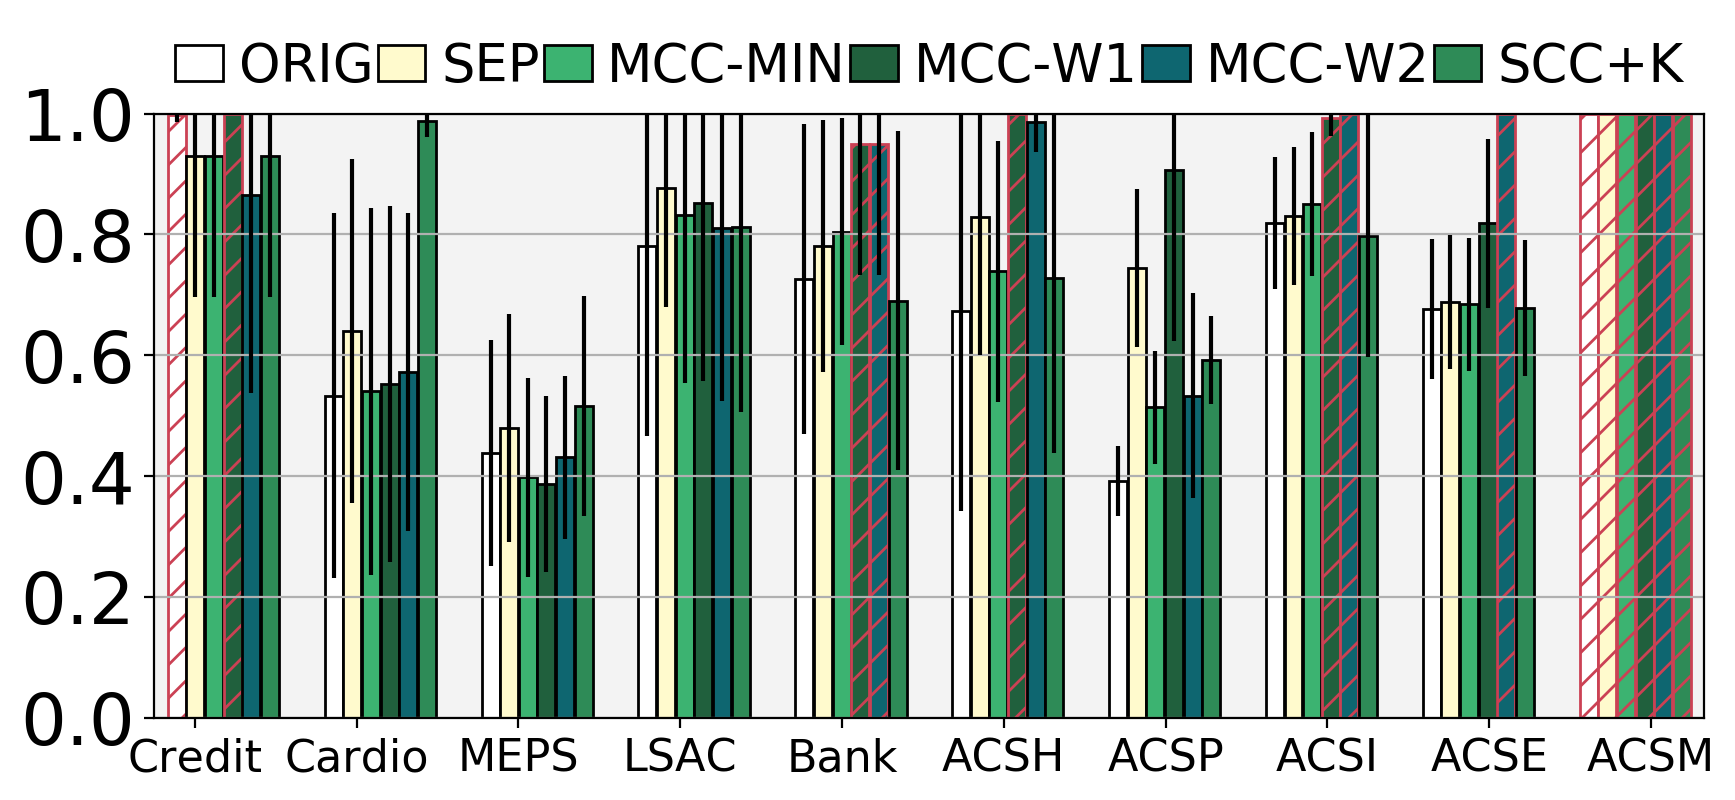

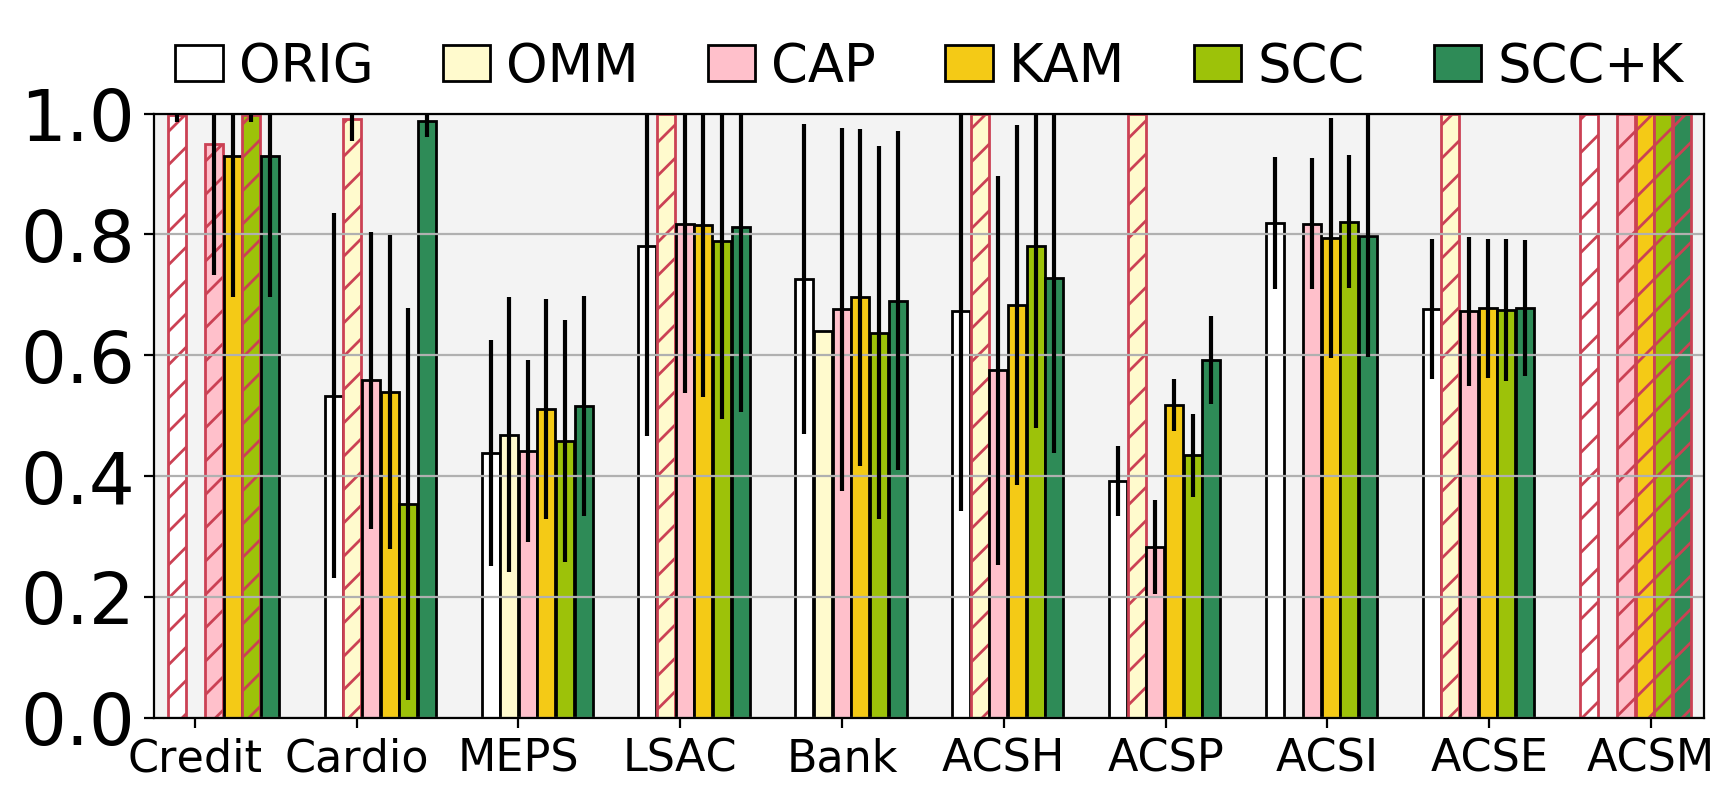

In [17]:
plot_path = 'intermediate/plots/'
exp_datasets = ['credit', 'cardio', 'meps16', 'lsac', 'bank', 'ACSH', 'ACSP', 'ACSI', 'ACSE', 'ACSM']
exp_ticks = ['Credit', 'Cardio', 'MEPS', 'LSAC', 'Bank', 'ACSH', 'ACSP', 'ACSI', 'ACSE', 'ACSM']

mcc_setttings = ['ORIG', 'SEP', 'MCC-MIN', 'MCC-W1', 'MCC-W2', 'SCC-KAM']
mcc_legends = ['ORIG', 'SEP', 'MCC-MIN', 'MCC-W1', 'MCC-W2', 'SCC+K']
mcc_colors = ['#ffffff', '#fffacd', '#3cb371','#20603d', '#0e6670', '#2e8b57']

scc_settings = ['ORIG', 'OMN-ONE', 'KAM-ONE', 'SCC-ONE', 'SCC-KAM']
scc_legends = ['ORIG', 'OMN', 'KAM', 'SCC', 'SCC+K']
scc_colors = ['#ffffff', '#fffacd', '#f4ca16', '#9dc209', '#2e8b57']

# eval_metrics = ['BalAcc', 'DI', 'AvgOddsDiff', 'EQDiff', 'FPRDiff', 'FNRDiff', 'ERRDiff']

eval_metrics = ['FPRDiff', 'FNRDiff']

for model_name in models[1:]:
    if model_name == 'TR':
        scc_colors = ['#ffffff', '#fffacd', '#ffc0cb', '#f4ca16', '#9dc209', '#2e8b57'] # '#ffdab9', '#006400'
        scc_settings = ['ORIG', 'OMN-ONE', 'CAP-ONE', 'KAM-ONE', 'SCC-ONE', 'SCC-KAM']
        scc_legends = ['ORIG', 'OMM', 'CAP', 'KAM', 'SCC', 'SCC+K']
        
        x_tick_sets = [7.2, 7.2]
    else:
        x_tick_sets = [7.2, 6.3]
    vis_df = eval_df.query('model=="{}"'.format(model_name))
    exp_path = plot_path+model_name+'/'
    
    for settings_i, colors_i, setting_name, legend_i, x_tick_set in zip([mcc_setttings, scc_settings], [mcc_colors, scc_colors], ['multi', 'single'], [mcc_legends, scc_legends], x_tick_sets):
#         print(vis_df.shape[0])
        for exp_metric in eval_metrics[1:]:
            output_name = '{}{}-{}-{}{}.png'.format(exp_path, model_name, setting_name, exp_metric, eval_suffix)
            bar_plots(vis_df, output_name, exp_datasets, exp_metric, settings_i, x_ticks=exp_ticks, colors=colors_i, 
                      legend_names=legend_i, x_tick_offset=x_tick_set,
                      legend_col=len(settings_i),
                      save_to_disc=False)

            

In [28]:

# exp_name = 'lr'

# # initiate a new folder for the plots
# # exp_path = plot_path+exp_name+'/'
# exp_path = plot_path+exp_name+'/'
# make_folder(exp_path)

# vis_df = eval_df.query('model=="{}"'.format(exp_name.upper()))

# exp_settings = ['ORIG', 'SEP', 'MCC-MIN', 'MCC-W2'] #'MCC-W1', 
# # exp_settings = ['ORIG', 'OMN-ONE', 'KAM-ONE', 'SCC-KAM']

# # exp_settings = ['OMN-ONE', 'SCC-OMN', 'KAM-ONE', 'SCC-KAM']

# exp_datasets = ['credit', 'cardio', 'meps16', 'lsac', 'bank', 'ACSH', 'ACSP', 'ACSI', 'ACSE', 'ACSM']
# exp_ticks = ['Credit', 'Cardio', 'MEPS', 'LSAC', 'Bank', 'ACSH', 'ACSP', 'ACSI', 'ACSE', 'ACSM']

# exp_metric = 'BalAcc'
# bar_plots(vis_df, exp_name, exp_datasets, exp_metric, exp_settings, x_ticks=exp_ticks, plot_path=exp_path)


In [25]:
# exp_metric = 'DI'
# bar_plots(vis_df, exp_name, exp_datasets, exp_metric, exp_settings, x_ticks=exp_ticks, plot_path=exp_path)


In [26]:
# exp_metric = 'FPRDiff'
# bar_plots(vis_df, exp_name, exp_datasets, exp_metric, exp_settings, x_ticks=exp_ticks, plot_path=exp_path)


In [27]:
# exp_metric = 'FNRDiff'
# bar_plots(vis_df, exp_name, exp_datasets, exp_metric, exp_settings, x_ticks=exp_ticks, plot_path=exp_path)


In [28]:
# exp_metric = 'ERRDiff'
# bar_plots(vis_df, exp_name, exp_datasets, exp_metric, exp_settings, x_ticks=exp_ticks, plot_path=exp_path)


In [29]:
# exp_metric = 'EQDiff'
# bar_plots(vis_df, exp_name, exp_datasets, exp_metric, exp_settings, x_ticks=exp_ticks, plot_path=exp_path)


In [30]:
# exp_metric = 'AvgOddsDiff'
# bar_plots(vis_df, exp_name, exp_datasets, exp_metric, exp_settings, x_ticks=exp_ticks, plot_path=exp_path)
